In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *

In [3]:
!cd ./fastbook

/bin/bash: line 1: cd: ./fastbook: No such file or directory


In [4]:
!pwd

/content


In [5]:
!git clone https://github.com/badaru-musa/fastbook.git

Cloning into 'fastbook'...
remote: Enumerating objects: 2753, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 2753 (delta 0), reused 5 (delta 0), pack-reused 2743 (from 1)
Receiving objects: 100% (2753/2753), 85.64 MiB | 14.04 MiB/s, done.
Resolving deltas: 100% (1578/1578), done.


# Image Classification

## From Dogs and Cats to Pet Breeds

In [6]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

<div><progress max="811706944" value="811712512"></progress> 100.00% [811712512/811706944 01:03&lt;00:00]</div>

In [7]:
#hide
Path.BASE_PATH = path

In [8]:
path.ls()

[Path('images'), Path('annotations')]

In [9]:
(path/"images").ls()

(#7393) [Path('images/havanese_115.jpg'), Path('images/japanese_chin_117.jpg'), Path('images/newfoundland_192.jpg'), Path('images/pomeranian_143.jpg'), Path('images/saint_bernard_1.jpg'), Path('images/miniature_pinscher_31.jpg'), Path('images/scottish_terrier_32.jpg'), Path('images/english_setter_97.jpg'), Path('images/Persian_38.jpg'), Path('images/pomeranian_51.jpg'), Path('images/boxer_48.jpg'), Path('images/keeshond_184.jpg'), Path('images/samoyed_188.jpg'), Path('images/basset_hound_148.jpg'), Path('images/shiba_inu_34.jpg'), Path('images/Siamese_44.jpg'), Path('images/saint_bernard_45.jpg'), Path('images/Persian_43.jpg'), Path('images/english_setter_98.jpg'), Path('images/beagle_120.jpg'), Path('images/beagle_103.jpg'), Path('images/yorkshire_terrier_125.jpg'), Path('images/yorkshire_terrier_95.jpg'), Path('images/english_setter_21.jpg'), Path('images/miniature_pinscher_29.jpg'), Path('images/Abyssinian_213.jpg'), Path('images/Persian_11.jpg'), Path('images/Abyssinian_223.jpg'), 

In [ ]:
fname = (path/"images").ls()[0]

In [11]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['havanese']

In [12]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [ ]:
dls.train[0]

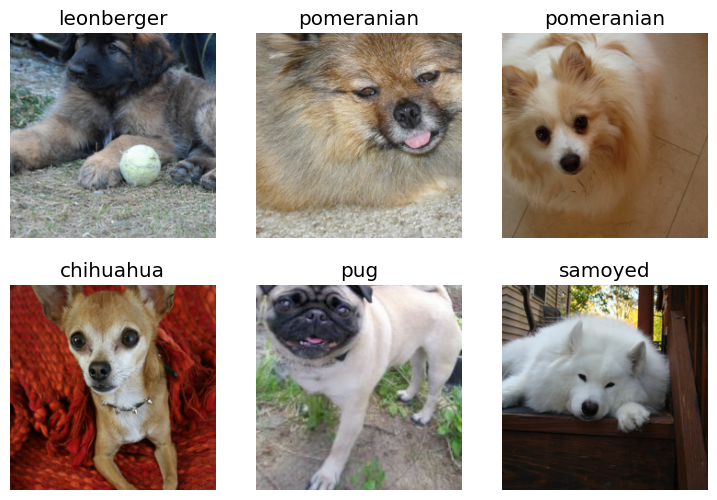

In [13]:
dls.show_batch(max_n=6)

## Presizing

In [ ]:
Path.cwd()

Path('/content')

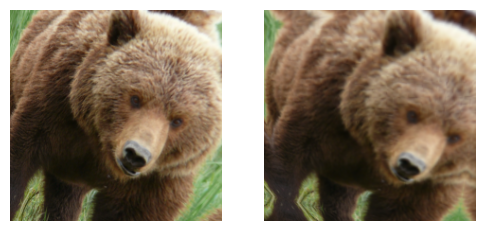

In [15]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
# Place an image in the 'images/grizzly.jpg' subfolder where this notebook is located before running this
dls1 = dblock1.dataloaders([(Path.cwd()/'fastbook'/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Checking and Debugging a DataBlock

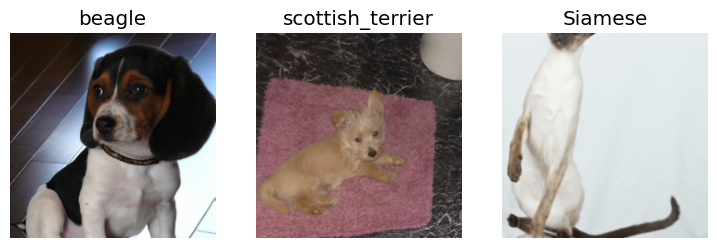

In [16]:
dls.show_batch(nrows=1, ncols=3)

In [18]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}


Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Siamese_47.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=392x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Siamese_47.jpg
    applying partial gives
      Siamese
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
 gives
      TensorCategory(10)

Final sample: (PILImage mode=RGB size=392x500, TensorCategory(10))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Setting up after_item: Pip

RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `TensorImage`:
	Item at index 0 has shape: torch.Size([3, 500, 392])
	Item at index 1 has shape: torch.Size([3, 375, 500])

Please include a transform in `after_item` that ensures all data of type TensorImage is the same size

In [19]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
with learn.no_bar():
    learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 107MB/s] 


[0, 1.4940884113311768, 0.41095882654190063, 0.14073072373867035, '01:03']
[0, 0.49205589294433594, 0.280612587928772, 0.09269282966852188, '01:05']
[1, 0.3214009404182434, 0.22584091126918793, 0.07307171821594238, '01:04']


## Cross-Entropy Loss

### Viewing Activations and Labels

In [20]:
x,y = dls.one_batch()

In [21]:
y

TensorCategory([28,  5, 13, 21,  0,  7, 25,  7, 30,  2, 12, 19, 25, 28, 13, 18, 20, 14, 19,  3,  9, 36,  5, 33, 18, 35,  2, 10, 18, 32, 31, 14, 17, 29, 14,  9, 31, 32, 34, 17, 18, 31,  3, 28, 20, 24,
                 9, 11, 16,  2, 10, 18,  1, 13, 16, 19, 35, 23,  3, 20,  2,  6,  4, 22], device='cuda:0')

In [22]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.5435e-07, 1.0493e-08, 5.9314e-05, 1.5053e-06, 2.7180e-08, 5.0356e-09, 1.2742e-06, 2.5930e-05, 1.8984e-05, 1.4705e-08, 6.4118e-08, 5.2651e-08, 6.3107e-09, 1.3599e-06, 3.0503e-08, 5.0918e-08,
        1.6835e-08, 2.3178e-05, 2.2977e-08, 8.9866e-08, 8.0397e-08, 8.7854e-08, 6.4796e-07, 9.9443e-06, 6.3635e-05, 3.1393e-07, 1.5470e-06, 9.8631e-07, 9.9975e-01, 3.1615e-07, 4.2494e-08, 5.3069e-07,
        1.2802e-06, 6.4245e-07, 2.4173e-08, 1.0667e-08, 3.3980e-05])

In [23]:
len(preds[0]),preds[0].sum()

(37, tensor(1.))

### Softmax

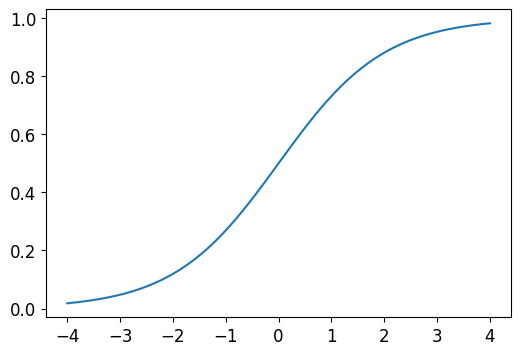

In [24]:
plot_function(torch.sigmoid, min=-4,max=4)

In [25]:
#hide
torch.random.manual_seed(42);

In [26]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [27]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [28]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [29]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log Likelihood

In [30]:
targ = tensor([0,1,0,1,1,0])

In [31]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [32]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [33]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['result'] = sm_acts[range(6), targ]
t = df.style.hide(axis="index")
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,result
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [34]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [35]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

#### Taking the Log

Recall that cross entropy loss may involve the multiplication of many numbers.  Multiplying lots of negative numbers together can cause problems like [numerical underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow) in computers.  Therefore, we want to transform these probabilities to larger values so we can perform mathematical operations on them.  There is a mathematical function that does exactly this: the *logarithm* (available as `torch.log`). It is not defined for numbers less than 0, and looks like this between 0 and 1:

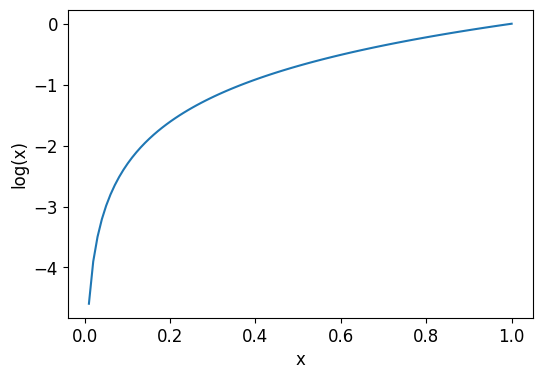

In [36]:
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

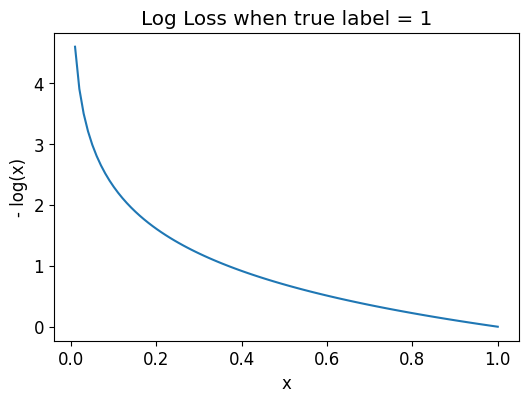

In [37]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='- log(x)', title = 'Log Loss when true label = 1')

In [38]:
from IPython.display import HTML
df['loss'] = -torch.log(tensor(df['result']))
t = df.style.hide(axis="index")
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,result,loss
0.602469,0.397531,0,0,0.602469,0.506720
0.502065,0.497935,1,1,0.497935,0.697285
0.133188,0.866811,0,2,0.133188,2.015990
0.996640,0.003360,1,3,0.003360,5.695763
0.595949,0.404051,1,4,0.404051,0.906213
0.366118,0.633882,0,5,0.366118,1.004798


### Negative Log Likelihood

In [39]:
loss_func = nn.CrossEntropyLoss()

In [40]:
loss_func(acts, targ)

tensor(1.8045)

In [41]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [42]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

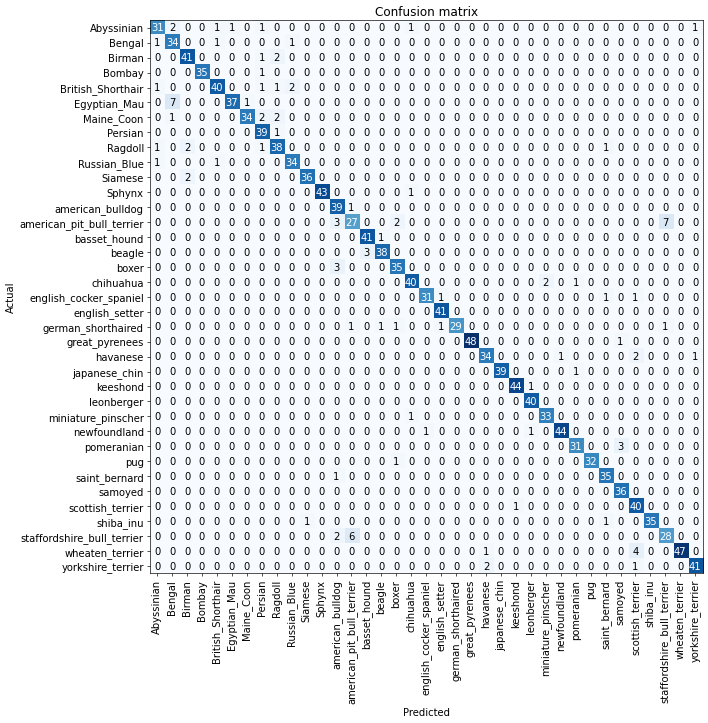

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [44]:
interp.most_confused(min_val=5)

[('Egyptian_Mau', 'Bengal', np.int64(7)),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', np.int64(7)),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', np.int64(6))]

## Improving Our Model

### The Learning Rate Finder

In [45]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
with learn.no_bar():
    learn.fine_tune(1, base_lr=0.1)

[0, 2.6000607013702393, 4.466660976409912, 0.41677942872047424, '01:03']
[0, 3.2655482292175293, 1.5654644966125488, 0.46008118987083435, '01:05']


<div></div>

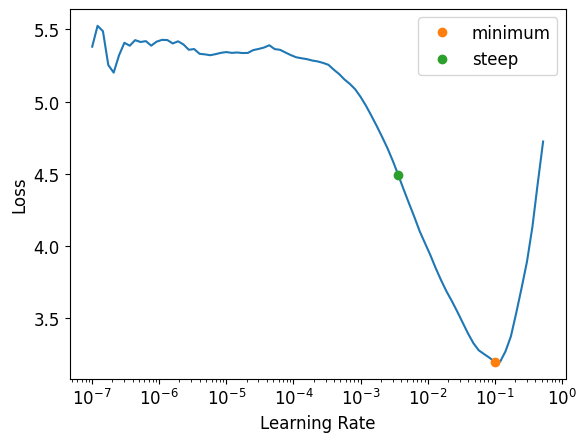

In [46]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [54]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 3.63e-03


In [55]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
with learn.no_bar():
    learn.fine_tune(2, base_lr=3e-3)

[0, 1.3307898044586182, 0.3282093107700348, 0.11096075922250748, '01:02']
[0, 0.5292736291885376, 0.30211886763572693, 0.10148850083351135, '01:06']
[1, 0.3282291293144226, 0.23318667709827423, 0.07442490011453629, '01:07']


### Unfreezing and Transfer Learning

In [56]:
learn.fine_tune??

Signature: learn.fine_tune(epochs, base_lr=0.002, freeze_epochs=1, lr_mult=100, pct_start=0.3, div=5.0, *, lr_max=None, div_final=100000.0, wd=None, moms=None, cbs=None, reset_opt=False, start_epoch=0)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      /usr/local/lib/python3.12/dist-packages/fastai/callback/schedule.py
Type:      method


In [57]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
with learn.no_bar():
    learn.fit_one_cycle(3, 3e-3)

[0, 1.1383099555969238, 0.28819790482521057, 0.0981055498123169, '01:04']
[1, 0.504442036151886, 0.24476183950901031, 0.0771312564611435, '01:02']
[2, 0.32550567388534546, 0.22488795220851898, 0.08051420748233795, '01:04']


In [58]:
learn.unfreeze()

<div></div>

SuggestedLRs(valley=3.630780702224001e-05)

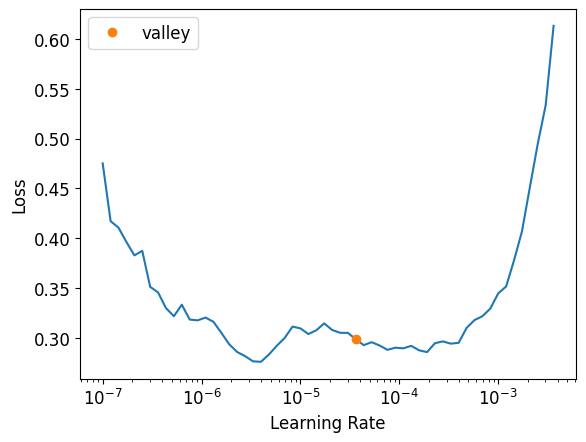

In [59]:
learn.lr_find()

In [60]:
with learn.no_bar():
    learn.fit_one_cycle(6, lr_max=1e-5)

[0, 0.2677333652973175, 0.22155821323394775, 0.0771312564611435, '01:06']
[1, 0.25992661714553833, 0.21310009062290192, 0.07036536186933517, '01:07']
[2, 0.23613563179969788, 0.2100134640932083, 0.0798376202583313, '01:07']
[3, 0.19666066765785217, 0.20660437643527985, 0.07171853631734848, '01:06']
[4, 0.18466822803020477, 0.20357337594032288, 0.07104194909334183, '01:05']
[5, 0.1824505776166916, 0.2044103741645813, 0.07239513099193573, '01:07']


### Discriminative Learning Rates

In [61]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
with learn.no_bar():
    learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
with learn.no_bar():
    learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

[0, 1.1728696823120117, 0.33340755105018616, 0.10690122097730637, '01:05']
[1, 0.5242180824279785, 0.24831412732601166, 0.07577808201313019, '01:03']
[2, 0.3196463882923126, 0.23101453483104706, 0.08051420748233795, '01:05']
[0, 0.26744893193244934, 0.22100530564785004, 0.07239513099193573, '01:07']
[1, 0.23903349041938782, 0.21228818595409393, 0.07577808201313019, '01:06']
[2, 0.23165170848369598, 0.2182246297597885, 0.07104194909334183, '01:07']
[3, 0.21611443161964417, 0.20716552436351776, 0.06901217997074127, '01:06']
[4, 0.18964457511901855, 0.20922914147377014, 0.06968876719474792, '01:03']
[5, 0.17777658998966217, 0.20038415491580963, 0.06427604705095291, '01:06']
[6, 0.14556783437728882, 0.19542261958122253, 0.06292286515235901, '01:05']
[7, 0.14064030349254608, 0.19990040361881256, 0.06495264172554016, '01:02']
[8, 0.143997922539711, 0.19151832163333893, 0.05953991785645485, '01:04']
[9, 0.13486333191394806, 0.19223088026046753, 0.06089309975504875, '01:04']
[10, 0.12532407045

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

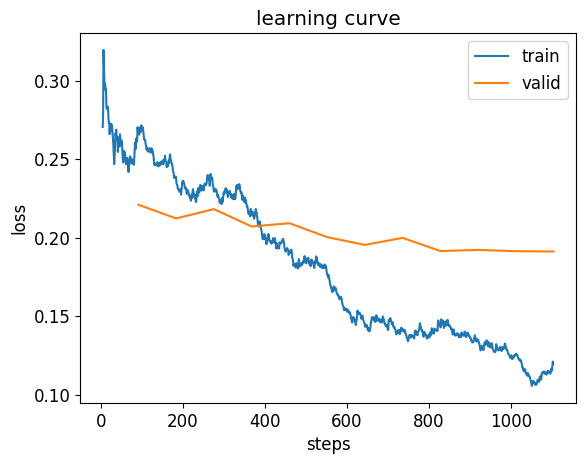

In [62]:
learn.recorder.plot_loss()

### Selecting the Number of Epochs

### Deeper Architectures

In [64]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
with learn.no_bar():
    learn.fine_tune(6, freeze_epochs=3)

[0, 2.234030246734619, 0.4680749773979187, 0.14682002365589142, '01:03']
[1, 0.8377450704574585, 0.333867609500885, 0.10351826995611191, '01:02']
[2, 0.5456931591033936, 0.29589906334877014, 0.09066306054592133, '01:02']
[0, 0.28043481707572937, 0.2362847626209259, 0.07374830543994904, '01:04']
[1, 0.2501320242881775, 0.23149505257606506, 0.06698241084814072, '01:05']
[2, 0.19664175808429718, 0.22879254817962646, 0.06562922894954681, '01:04']
[3, 0.13090331852436066, 0.20227456092834473, 0.05480378866195679, '01:04']
[4, 0.09232062846422195, 0.18747635185718536, 0.05209742859005928, '01:01']
[5, 0.0677003562450409, 0.19014310836791992, 0.05548037961125374, '01:03']


## Conclusion

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
1. Look up the documentation for `L` and try using a few of the new methods that it adds.
1. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a `DataLoaders`?
1. What method does fastai provide to help you debug a `DataBlock`?
1. Should you hold off on training a model until you have thoroughly cleaned your data?
1. What are the two pieces that are combined into cross-entropy loss in PyTorch?
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
1. What two steps does the `fine_tune` method do?
1. In Jupyter Notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python `slice` object interpreted when passed as a learning rate to fastai?
1. Why is early stopping a poor choice when using 1cycle training?
1. What is the difference between `resnet50` and `resnet101`?
1. What does `to_fp16` do?

### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.

In [72]:
#Classifier accuracy trial
learn = vision_learner(dls, resnet101, metrics=error_rate)

with learn.no_bar():
    learn.fine_tune(12, freeze_epochs=3,)

[0, 2.252512216567993, 0.45554453134536743, 0.12787550687789917, '01:34']
[1, 0.8431023359298706, 0.29137784242630005, 0.09607578068971634, '01:34']
[2, 0.5462518930435181, 0.3022603988647461, 0.09472259879112244, '01:34']
[0, 0.28052133321762085, 0.20363114774227142, 0.06292286515235901, '02:02']
[1, 0.20887495577335358, 0.18388314545154572, 0.05480378866195679, '02:00']
[2, 0.19434744119644165, 0.2319832742214203, 0.07374830543994904, '02:00']
[3, 0.16923697292804718, 0.24785205721855164, 0.06359945982694626, '02:01']
[4, 0.12902024388313293, 0.21151518821716309, 0.057510148733854294, '02:01']
[5, 0.09101051092147827, 0.21527351438999176, 0.05683355778455734, '02:01']
[6, 0.06880903989076614, 0.21550725400447845, 0.05548037961125374, '02:01']
[7, 0.052664827555418015, 0.21874010562896729, 0.05548037961125374, '02:01']
[8, 0.03710778430104256, 0.20804455876350403, 0.049391068518161774, '02:01']
[9, 0.03080149181187153, 0.20663443207740784, 0.04736129939556122, '02:00']
[10, 0.02462029

<div></div>

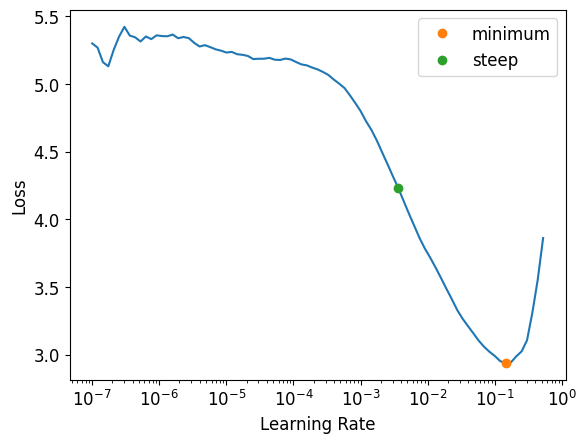

In [66]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))